<a href="https://colab.research.google.com/github/jwkanggist/EverybodyTensorflow2.0/blob/master/lab7_relu_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LAB7 Relu 사용해 보기

목적: Relu activation을 사용해서 vanishing Gradient Problem이 완화되는 것을 확인한다.

In [0]:
# preprocessor parts

from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import pandas as pd

from matplotlib import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt

from datetime import datetime

from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

TensorFlow 2.x selected.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
  # for Tensorboard use
  LOG_DIR = 'content/drive/data/tb_logs'
	
  !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
  !unzip ngrok-stable-linux-amd64.zip
	
  import os
  if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR)
	  
  get_ipython().system_raw(
      'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
      .format(LOG_DIR))
	
  get_ipython().system_raw('./ngrok http 6006 &')
	
  !curl -s http://localhost:4040/api/tunnels | python3 -c \
      "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2020-01-07 16:57:04--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.204.156.91, 52.204.223.154, 35.174.75.106, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.204.156.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  16.3MB/s    in 0.8s    

2020-01-07 16:57:06 (16.3 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
http://4b63df7e.ngrok.io


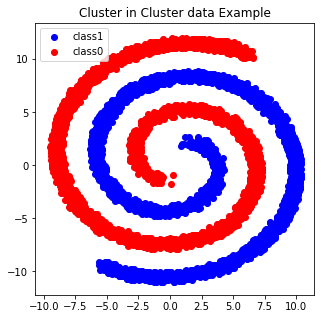

In [0]:
xsize  = 2
ysize  = 2

data = pd.read_csv('/content/drive/My Drive/seminar_materials/TensorFlow Lecture/KIT2020/data/lab45/twospirals_N5000.csv')
data.columns=['xdata1','xdata2','tdata']
permutation_index = np.random.permutation(data.index)
permutated_data = data.reindex(permutation_index)
permutated_data.columns=['xdata1','xdata2','tdata']

x_data = np.zeros([permutated_data.xdata1.size,xsize])
x_data[:,0] = permutated_data.xdata1.values
x_data[:,1] = permutated_data.xdata2.values

t_data = np.zeros([permutated_data.tdata.size,ysize])
t_data[:,0] = permutated_data.tdata.values
t_data[:,1] = np.invert(permutated_data.tdata.values) + 2


total_size = permutated_data.xdata1.size
training_size = int(np.floor(permutated_data.xdata1.size * 0.8))
validation_size = total_size - training_size



# data dividing
x_train = x_data[0:training_size,:]
y_train = t_data[0:training_size,:]

x_test = x_data[training_size:-1,:]
y_test = t_data[training_size:-1,:]

# #data plot
hfig1= plt.figure(1,figsize=[5,5])
plt.scatter(data.xdata1.values[0:int(data.xdata1.size/2)],\
            data.xdata2.values[0:int(data.xdata1.size/2)], \
            color='b',label='class1')
plt.scatter(data.xdata1.values[int(data.xdata1.size/2)+2:-1],\
            data.xdata2.values[int(data.xdata1.size/2)+2:-1], \
            color='r',label='class0')
plt.title('Cluster in Cluster data Example')
plt.legend()

plt.show()

In [0]:
# model building and training setting part

# Network Parameters
# Network Parameters
n_hidden_1 = 16 # 1st layer number of neurons
n_hidden_2 = 16 # 2nd layer number of neurons
n_hidden_3 = 16 # 3rd layer number of neurons
n_hidden_4 = 24 # 4rd layer number of neurons
n_hidden_5 = 24 # 5rd layer number of neurons
n_hidden_6 = 16 # 1st layer number of neurons
n_hidden_7 = 12 # 2nd layer number of neurons
n_hidden_8 = 7 # 3rd layer number of neurons
n_hidden_9 = 4 # 4rd layer number of neurons
n_hidden_10 = 4 # 5rd layer number of neurons
num_input = xsize   # two-dimensional input X = [1x2]
num_classes = ysize # 2 class

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(n_hidden_1, activation='relu'),
  tf.keras.layers.Dense(n_hidden_2, activation='relu'),
  tf.keras.layers.Dense(n_hidden_3, activation='relu'),
  tf.keras.layers.Dense(n_hidden_4, activation='relu'),
  tf.keras.layers.Dense(n_hidden_5, activation='relu'),
  tf.keras.layers.Dense(n_hidden_6, activation='relu'),
  tf.keras.layers.Dense(n_hidden_7, activation='relu'),
  tf.keras.layers.Dense(n_hidden_8, activation='relu'),
  tf.keras.layers.Dense(n_hidden_9, activation='relu'),
  tf.keras.layers.Dense(n_hidden_10, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='linear')
])

opt_fn = tf.keras.optimizers.Adam(learning_rate=1e-5,
                                beta_1=0.9,
                                beta_2=0.999)


model.compile(optimizer=opt_fn,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

tensorboard_callback = TensorBoard(log_dir=LOG_DIR, 
                           histogram_freq=1,
                           write_graph=True,
                           write_images=True)

In [0]:
# model training and evaluation part
training_epochs = 5
batch_size = 128

model.fit(x_train, y_train, 
          epochs=training_epochs,
          validation_data=(x_test, y_test),
          batch_size=batch_size,
          callbacks=[tensorboard_callback])
model.evaluate(x_test,  y_test, verbose=2)

Train on 3999 samples, validate on 999 samples
Epoch 1/5
3999/3999 [==============================] - 1s 240us/sample - loss: 0.7135 - accuracy: 0.5009 - val_loss: 0.7151 - val_accuracy: 0.4965
Epoch 2/5
3999/3999 [==============================] - 0s 23us/sample - loss: 0.7133 - accuracy: 0.5009 - val_loss: 0.7150 - val_accuracy: 0.4965
Epoch 3/5
3999/3999 [==============================] - 0s 24us/sample - loss: 0.7131 - accuracy: 0.5009 - val_loss: 0.7148 - val_accuracy: 0.4965
Epoch 4/5
3999/3999 [==============================] - 0s 23us/sample - loss: 0.7129 - accuracy: 0.5009 - val_loss: 0.7146 - val_accuracy: 0.4965
Epoch 5/5
3999/3999 [==============================] - 0s 24us/sample - loss: 0.7127 - accuracy: 0.5009 - val_loss: 0.7144 - val_accuracy: 0.4965
999/999 - 0s - loss: 0.7144 - accuracy: 0.4965


[0.7143823022956963, 0.4964965]